In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.utils import np_utils




data = pd.read_csv("Alzheimer's.csv")

#categorical conversion 
#Converted the group to dummy variables
data.loc[data.Group=='Nondemented', 'Group'] = 0
data.loc[data.Group=='Demented', 'Group'] = 1
data.loc[data.Group=='Converted', 'Group'] = 2

#Converted the M/F to dummy variables
data.loc[data.Sex=='M', 'Sex'] = 0
data.loc[data.Sex=='F', 'Sex'] = 1

#ToDo
#Fill in SES and Mini Mental State missing sample values
#Use the mean of that category for the value
# Get rid of SES data 

data

,Subject ID,MRI ID,Group,Visit,MR Delay,Sex,Hand,Age,EDUC,SES,Mini Mental State,Clinical Dementia Rating,Estimated total Intracranial Volume,Normalize Whole Brain Volume,Atlas Scaling Factor
0,OAS2_0001,OAS2_0001_MR1,0,1,0,0,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,0,2,457,0,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,1,1,0,0,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,1,2,560,0,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,1,3,1895,0,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,1,2,842,0,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,1,3,2297,0,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,0,1,0,1,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,0,2,763,1,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


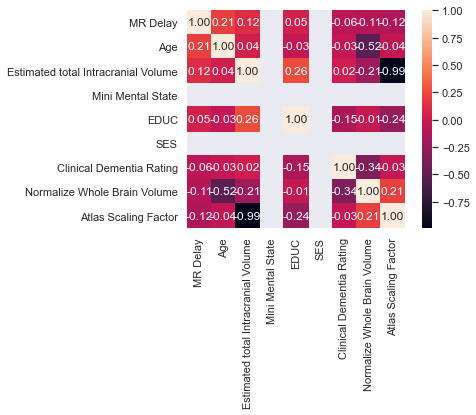

In [2]:
#Attempting PCA on data
#Hand is completely useless as it is identical for all samples
data_drop = data.drop(['Hand','Visit','Subject ID','MRI ID'], axis = 1) #axis = 1 means to drop column not row

#get rid of row 360 and 359 bc they are missing alot of data (both SES and MMS)
data_drop = data_drop.drop([360, 359])


#delete all data points that dont have SES in them (this is where they have NaN)
data_drop = data_drop.dropna()


from sklearn.model_selection import cross_val_score
correlation = data_drop.corr(method='pearson')
#we will us the top 10 here because the plot becomes unreadable at 20 predictors
columns = correlation.nlargest(10, 'MR Delay').index

import seaborn as sns
correlation_map = np.corrcoef(data[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)



#dementia status is what we want to predict - change this to single target 
group = data_drop[['Group']] 








In [3]:
data_drop = data_drop.drop(['Group'], axis = 1) #axis = 1 means to drop column not row

In [4]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(data_drop)
data_drop.info()

     MR Delay Sex  Age  EDUC  SES  Mini Mental State  \
0           0   0   87    14  2.0               27.0   
1         457   0   88    14  2.0               30.0   
5           0   1   88    18  3.0               28.0   
6         538   1   90    18  3.0               27.0   
7           0   0   80    12  4.0               28.0   
8        1010   0   83    12  4.0               29.0   
9        1603   0   85    12  4.0               30.0   
13          0   1   93    14  2.0               30.0   
14        742   1   95    14  2.0               29.0   
15          0   0   68    12  2.0               27.0   
16        576   0   69    12  2.0               24.0   
17          0   1   66    12  3.0               30.0   
18        854   1   68    12  3.0               29.0   
19          0   1   78    16  2.0               29.0   
20        730   1   80    16  2.0               29.0   
21       1598   1   83    16  2.0               29.0   
22          0   1   81    12  4.0               

In [5]:
#get a list of columns in pandas object 
names_of_data = data_drop.columns.tolist()

#shuffle = false prevents data split being different everytime
X_train, X_test, y_train, y_test = train_test_split(data_drop, group, test_size=0.2, shuffle = False)

#split train into validate and test, again making sure the data is always the same for consistency
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle = True)

#Normalizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)



#running the actual PCA
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


y_train = y_train.astype('int').to_numpy().ravel()
y_test = y_test.astype('int').to_numpy().ravel()
y_val = y_val.astype('int').to_numpy().ravel()

y_train = np_utils.to_categorical(y_train, 3)
y_test = np_utils.to_categorical(y_test, 3)
y_val = np_utils.to_categorical(y_val, 3)




In [6]:


#lets use a neural network for this example
from keras.utils import np_utils
from tensorflow.keras.datasets import mnist
import seaborn as sns
from tensorflow.keras.initializers import RandomNormal

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time



In [7]:
from keras.layers import Activation, Dense
from keras.models import Sequential 

model = Sequential()
model.add(Dense(500, input_dim=10))#5
model.add(Activation('relu'))
# model.add(Dense(5, input_dim=5))#5
# model.add(Activation('relu'))


model.add(Dense(3, input_dim=5))#5
model.add(Activation('sigmoid'))

#model.add(Activation('softmax'))
model.compile(optimizer='sgd', loss='CategoricalCrossentropy',
             metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               5500      
_________________________________________________________________
activation (Activation)      (None, 500)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1503      
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 7,003
Trainable params: 7,003
Non-trainable params: 0
_________________________________________________________________


In [8]:
epoch = 100#100
training = model.fit(X_train, y_train, batch_size=60, epochs=epoch,
                    verbose=1, shuffle=True, validation_data=(X_val,y_val))#60



Epoch 1/100
5/5 [==============================] - 1s 137ms/step - loss: 1.1256 - accuracy: 0.2606 - val_loss: 1.0573 - val_accuracy: 0.4483
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 1.0647 - accuracy: 0.4654 - val_loss: 1.0489 - val_accuracy: 0.5172
Epoch 3/100
5/5 [==============================] - 0s 12ms/step - loss: 1.0255 - accuracy: 0.6046 - val_loss: 1.0389 - val_accuracy: 0.5517
Epoch 4/100
5/5 [==============================] - 0s 11ms/step - loss: 0.9853 - accuracy: 0.6736 - val_loss: 1.0348 - val_accuracy: 0.5517
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 0.9503 - accuracy: 0.7181 - val_loss: 1.0323 - val_accuracy: 0.5172
Epoch 6/100
5/5 [==============================] - 0s 9ms/step - loss: 0.9133 - accuracy: 0.7462 - val_loss: 1.0327 - val_accuracy: 0.4828
Epoch 7/100
5/5 [==============================] - 0s 9ms/step - loss: 0.8874 - accuracy: 0.7496 - val_loss: 1.0370 - val_accuracy: 0.5172
Epoch 8/100
5/5 [====

5/5 [==============================] - 0s 9ms/step - loss: 0.4340 - accuracy: 0.8685 - val_loss: 1.8327 - val_accuracy: 0.2414
Epoch 60/100
5/5 [==============================] - 0s 9ms/step - loss: 0.4246 - accuracy: 0.8727 - val_loss: 1.8498 - val_accuracy: 0.2414
Epoch 61/100
5/5 [==============================] - 0s 9ms/step - loss: 0.4062 - accuracy: 0.8746 - val_loss: 1.8652 - val_accuracy: 0.2414
Epoch 62/100
5/5 [==============================] - 0s 9ms/step - loss: 0.4087 - accuracy: 0.8753 - val_loss: 1.8778 - val_accuracy: 0.2414
Epoch 63/100
5/5 [==============================] - 0s 10ms/step - loss: 0.4258 - accuracy: 0.8510 - val_loss: 1.8941 - val_accuracy: 0.2414
Epoch 64/100
5/5 [==============================] - 0s 9ms/step - loss: 0.3918 - accuracy: 0.8903 - val_loss: 1.9094 - val_accuracy: 0.2414
Epoch 65/100
5/5 [==============================] - 0s 9ms/step - loss: 0.4302 - accuracy: 0.8599 - val_loss: 1.9238 - val_accuracy: 0.2414
Epoch 66/100
5/5 [==============

In [9]:
performance = model.evaluate(X_val, y_val, verbose=0)

print("test score", performance[0]) 
print("test accuracy", performance[1])

#best performance was 0.769 accuracy

test score 2.4172308444976807
test accuracy 0.24137930572032928


<IPython.core.display.Javascript object>


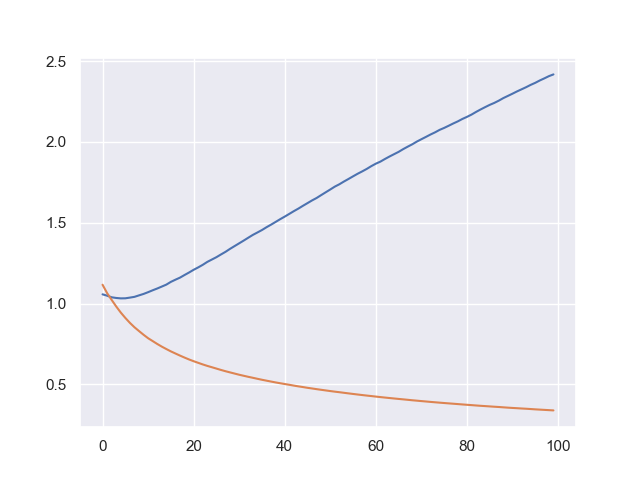

In [10]:
x = list(range(epoch))
vy = training.history['val_loss']
ty = training.history['loss']

plt.plot( x, vy )
plt.plot( x, ty )
plt.show()

